# Task
### Implement 3 clases for the active matter dataset:
- DataLoader
- Model
- Training class

References:
- https://github.com/hernanmorales-navarrete/EPIC_5/blob/main/Tutorials/tutorial_6/code/2_NoiseRemoval_Autoencoders.ipynb
- https://github.com/hernanmorales-navarrete/EPIC_5/blob/main/Tutorials/tutorial_6/code/3_ImageSegmentation_UNet.ipynb
- https://tutorial.rise-miccai.org/Beginner_tuto/Retina_classification_using_CNN_.html
- https://github.com/PolymathicAI/the_well
- https://polymathic-ai.org/the_well/tutorials/dataset/

In [1]:
import torch
import os

def check_device():
    """
    Checks if a CUDA-capable GPU is available, prints device info,
    and runs a small matrix multiplication test to confirm GPU functionality.
    Also prints the number of available CPU workers.
    """
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    else:
        device = torch.device("cpu")
        print("⚠️ No GPU found. Using CPU.")

    num_workers = os.cpu_count()
    print(f"🧠 Number of available CPU workers: {num_workers}")
    print(f"🖥️ Using device: {device}")

    # Simple test calculation
    try:
        a = torch.rand((1000, 1000), device=device)
        b = torch.rand((1000, 1000), device=device)
        c = torch.matmul(a, b)
        torch.cuda.synchronize() if device.type == 'cuda' else None
        print("✅ GPU test calculation completed successfully.")
    except Exception as e:
        print(f"❌ GPU test failed: {e}")

    return device

# Run the device check
device = check_device()

✅ GPU available: NVIDIA GeForce RTX 5060 Ti
🧠 Number of available CPU workers: 24
🖥️ Using device: cuda
✅ GPU test calculation completed successfully.


d:\Jhon\miniconda3\envs\DA_ML\Lib\site-packages\torch\cuda\__init__.py:287: UserWarning: 
NVIDIA GeForce RTX 5060 Ti with CUDA capability sm_120 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_61 sm_70 sm_75 sm_80 sm_86 sm_90 compute_37.
If you want to use the NVIDIA GeForce RTX 5060 Ti GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(


# 1 DataSet Class

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from the_well.data import WellDataset
from einops import rearrange


device = "cuda"
base_path = "./datasets"  # path/to/storage
stride = 20

In [ ]:
# from the_well.utils.download import well_download
# well_download(base_path=base_path, dataset="active_matter", split="train")
# well_download(base_path=base_path, dataset="active_matter", split="valid")
# well_download(base_path=base_path, dataset="active_matter", split="test")

In [4]:
# Loading the DataSet

dataset = WellDataset(
    well_base_path=f"{base_path}/datasets",
    well_dataset_name="active_matter",
    well_split_name="train",
    n_steps_input=4,
    n_steps_output=1,
    min_dt_stride=stride,
    use_normalization=True,
)

In [5]:
print(type(dataset), len(dataset))
x = dataset[42]
print(type(x),x.keys())
print(x['input_fields'].shape)
print(x['output_fields'].shape)


FF = dataset.metadata.n_fields
field_names = [
    name for group in dataset.metadata.field_names.values() for name in group
]
print(field_names)

<class 'the_well.data.datasets.WellDataset'> 175
<class 'dict'> dict_keys(['input_fields', 'output_fields', 'constant_scalars', 'boundary_conditions', 'space_grid', 'input_time_grid', 'output_time_grid'])
torch.Size([4, 256, 256, 11])
torch.Size([1, 256, 256, 11])
['concentration', 'velocity_x', 'velocity_y', 'D_xx', 'D_xy', 'D_yx', 'D_yy', 'E_xx', 'E_xy', 'E_yx', 'E_yy']


## Data point visualizer

In [6]:
def plot_sequence(datapoint):
    x = datapoint["input_fields"]
    y = datapoint["output_fields"]
    x = rearrange(x, "T Lx Ly F -> F T Lx Ly")
    y = rearrange(y, "T Lx Ly F -> F T Lx Ly")

    len_x = x.shape[1]
    len_y = y.shape[1]

    fig, axs = plt.subplots(FF, len_x + len_y, figsize=((len_x + len_y) * 1.3, FF * 1.2))

    for field in range(FF):
        vmin = np.nanmin(x[field])
        vmax = np.nanmax(x[field])

        axs[field, 0].set_ylabel(f"{field_names[field]}")

        for t in range(len_x):
            axs[field, t].imshow(
                x[field, t], cmap="viridis", interpolation="none", vmin=vmin, vmax=vmax
            )
            axs[field, t].set_xticks([])
            axs[field, t].set_yticks([])
            axs[0, t].set_title(f"$t_{t}$​")

        for t in range(len_y):
            axs[field, len_x + t].imshow(
                y[field, t], cmap="viridis", interpolation="none", vmin=vmin, vmax=vmax
            )
            axs[field, len_x + t].set_xticks([])
            axs[field, len_x + t].set_yticks([])
            axs[0, len_x + t].set_title(f"$tp_{t}$​")


    plt.tight_layout()
    plt.show()
    plt.close()

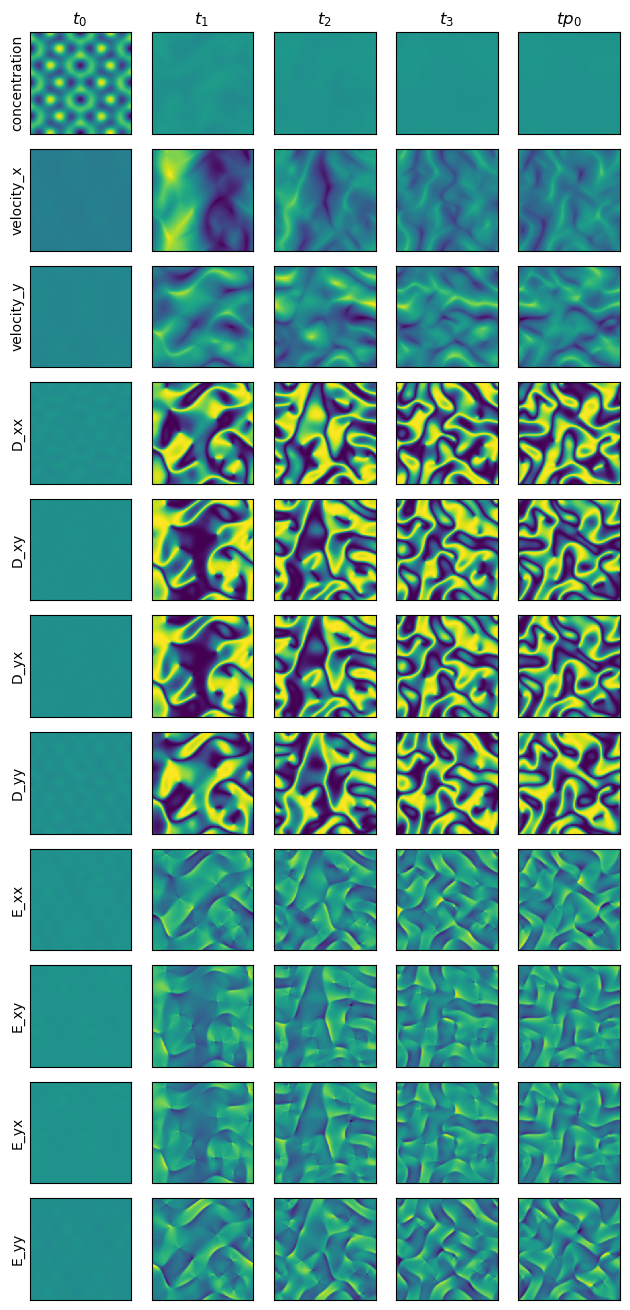

In [7]:
plot_sequence(dataset[42])

# 2 Model

CNextU-net
- Spatial filter size - 7
- Initial dimension - 42
- Blocks per stage - 2
- Up/Down blocks - 4
- Bottleneck blocks - 1

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F



#   ConvNeXt-like block 

class CNextBlock(nn.Module):
    def __init__(self, dim, kernel_size=7):
        super().__init__()
        padding = kernel_size // 2

        self.dwconv = nn.Conv2d(dim, dim, kernel_size, padding=padding, groups=dim)  # depthwise
        self.norm = nn.GroupNorm(1, dim)  # LayerNorm-like
        self.pwconv1 = nn.Conv2d(dim, 4 * dim, kernel_size=1)
        self.pwconv2 = nn.Conv2d(4 * dim, dim, kernel_size=1)
        self.act = nn.GELU()

    def forward(self, x):
        residual = x
        x = self.dwconv(x)
        x = self.norm(x)
        x = self.pwconv1(x)
        x = self.act(x)
        x = self.pwconv2(x)
        return x + residual



#   Basic Down Block

class DownStage(nn.Module):
    def __init__(self, in_dim, out_dim, num_blocks, kernel_size):
        super().__init__()
        self.blocks = nn.Sequential(*[
            CNextBlock(in_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])
        self.down = nn.Conv2d(in_dim, out_dim, kernel_size=2, stride=2)

    def forward(self, x):
        skip = self.blocks(x)
        down = self.down(skip)
        return skip, down




#   Basic Up Block

class UpStage(nn.Module):
    def __init__(self, in_dim, out_dim, num_blocks, kernel_size):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_dim, out_dim, kernel_size=2, stride=2)
        self.blocks = nn.Sequential(*[
            CNextBlock(out_dim, kernel_size=kernel_size) for _ in range(num_blocks)
        ])

    def forward(self, x, skip):
        x = self.up(x)

        # pad skip if size mismatch
        if x.shape[-1] != skip.shape[-1]:
            x = F.pad(x, (0, skip.shape[-1] - x.shape[-1], 0, skip.shape[-2] - x.shape[-2]))

        x = x + skip  # skip connection
        x = self.blocks(x)
        return x



#   CNext U-Net

class CNextUNet(nn.Module):
    def __init__(
        self,
        in_channels=1,
        out_channels=1,
        base_dim=42,
        num_stages=4,
        blocks_per_stage=2,
        bottleneck_blocks=1,
        kernel_size=7
    ):
        super().__init__()

        dims = [base_dim * (2 ** i) for i in range(num_stages)]

        # initial projection
        self.in_proj = nn.Conv2d(in_channels, dims[0], kernel_size=3, padding=1)

        # Down path
        self.downs = nn.ModuleList([
            DownStage(
                dims[i], dims[i + 1],
                num_blocks=blocks_per_stage,
                kernel_size=kernel_size
            ) for i in range(num_stages - 1)
        ])

        # Bottleneck
        self.bottleneck = nn.Sequential(*[
            CNextBlock(dims[-1], kernel_size=kernel_size)
            for _ in range(bottleneck_blocks)
        ])

        # Up path (reverse dims)
        self.ups = nn.ModuleList([
            UpStage(
                dims[i + 1], dims[i],
                num_blocks=blocks_per_stage,
                kernel_size=kernel_size
            ) for i in reversed(range(num_stages - 1))
        ])

        # output projection
        self.out_proj = nn.Conv2d(dims[0], out_channels, kernel_size=1)

    def forward(self, x):
        skips = []
        x = self.in_proj(x)

        # Down path
        for down in self.downs:
            skip, x = down(x)
            skips.append(skip)

        # Bottleneck
        x = self.bottleneck(x)

        # Up path (reverse order)
        for up in self.ups:
            skip = skips.pop()
            x = up(x, skip)

        return self.out_proj(x)



CNextU-net
- Spatial filter size - 7
- Initial dimension - 42
- Blocks per stage - 2
- Up/Down blocks - 4
- Bottleneck blocks - 1

In [9]:
model = CNextUNet(
    in_channels=44,   # 4 frames × 11 channels
    out_channels=11,  # 1 predicted frame
    base_dim=42,
    num_stages=4,
    blocks_per_stage=2,
    bottleneck_blocks=1,
    kernel_size=7
)

# 3 Training 

In [10]:
from tqdm import tqdm

print(len(dataset))

train_loader = torch.utils.data.DataLoader(
    dataset=dataset,
    shuffle=True,
    batch_size=10,
    num_workers=0,
)

175


In [11]:
valid_data = WellDataset(
    well_base_path=f"{base_path}/datasets",
    well_dataset_name="active_matter",
    well_split_name="valid",
    n_steps_input=4,
    n_steps_output=1,
    min_dt_stride=stride,
    use_normalization=True,
)

print(len(valid_data))

val_loader = torch.utils.data.DataLoader(
    dataset=valid_data,
    shuffle=True,
    batch_size=10,
    num_workers=0,
)

24


In [12]:
model = model.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
# criterion = nn.MSELoss()  # or L1Loss()

# Training parameters
num_epochs = 100
learning_rate = 0.005
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
patience = 5  # Early stopping patience

# Store losses
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0


for epoch in range(4):
    model.train()
    train_loss = 0.0
    for batch in (bar := tqdm(train_loader)):
        # data
        x = batch["input_fields"]
        y = batch["output_fields"]
        # Move channels last → channels first
        x = x.permute(0, 1, 4, 2, 3)   # (B,4,11,256,256)
        y = y.permute(0, 1, 4, 2, 3)   # (B,1,11,256,256)
        # Flatten temporal dimension into channels
        x = x.reshape(x.size(0), 4*11, 256, 256)  # (B,44,256,256)
        # Remove time dimension of target
        y = y.reshape(y.size(0), 11, 256, 256)     # (B,11,256,256)
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        pred = model(x)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Losses
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            # data
            x = batch["input_fields"]
            y = batch["output_fields"]
            # Move channels last → channels first
            x = x.permute(0, 1, 4, 2, 3)   # (B,4,11,256,256)
            y = y.permute(0, 1, 4, 2, 3)   # (B,1,11,256,256)
            # Flatten temporal dimension into channels
            x = x.reshape(x.size(0), 4*11, 256, 256)  # (B,44,256,256)
            # Remove time dimension of target
            y = y.reshape(y.size(0), 11, 256, 256)     # (B,11,256,256)
            x = x.to(device)
            y = y.to(device)

            # Forward pass
            pred = model(x)
            loss = criterion(pred, y)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print("Early stopping triggered")
        break

100%|██████████| 18/18 [00:07<00:00,  2.30it/s]


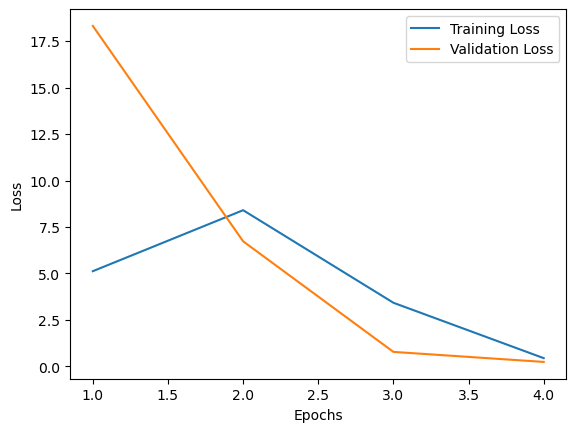

In [13]:
# Plotting the training and validation loss
plt.figure()
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test

In [14]:
test_data = WellDataset(
    well_base_path=f"{base_path}/datasets",
    well_dataset_name="active_matter",
    well_split_name="test",
    n_steps_input=4,
    n_steps_output=1,
    min_dt_stride=stride,
    use_normalization=True,
)

print(len(valid_data))

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    shuffle=True,
    batch_size=10,
    num_workers=0,
)

24


In [15]:
# Test loop
test_loss = 0.0
model.eval()
with torch.no_grad():
    for batch in test_loader:
        # data
        x = batch["input_fields"]
        y = batch["output_fields"]
        # Move channels last → channels first
        x = x.permute(0, 1, 4, 2, 3)   # (B,4,11,256,256)
        y = y.permute(0, 1, 4, 2, 3)   # (B,1,11,256,256)
        # Flatten temporal dimension into channels
        x = x.reshape(x.size(0), 4*11, 256, 256)  # (B,44,256,256)
        # Remove time dimension of target
        y = y.reshape(y.size(0), 11, 256, 256)     # (B,11,256,256)
        x = x.to(device)
        y = y.to(device)

        # Forward pass
        pred = model(x)
        loss = criterion(pred, y)
        test_loss += loss.item()

test_loss /= len(val_loader)
print(f'The test loss is: {test_loss}')

The test loss is: 0.24641803403695425
